![sf-weather](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/sf-weather.jpg)

# Weather prediction using Recurrent Neural Network
### Dr. Tirthajyoti Sarkar, Fremont, CA ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---

In this Notebook, we show how the long-term trend of key weather parameters (humidity, temperature, atmospheric pressure, etc.) can be predicted with decent accuracy using simple recurrent neural network (RNN). We don't even need to use any sophisticated memory module like GRU or LSTM for this. A simple one-layer RNN based model seems sufficient to be able to predict long-term trends from limited training data surprisingly well.

This is almost a proof of what Andrej Karpathy famously called **["The unusual effectiveness of recurrent neural networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)**

### The dataset
The dataset consists of historical weather parameters (temperature, pressure, relative humidity) for major North American and other cities around the world over an extended time period of 2012 to 2017. Hourly data points are recorded, giving, over 45000 data points, in total.

By attepmpting to do a time-series prediction, we are implicitly assuming that the past weather pattern is a good indicator of the future.

For this analysis, we focus only on the data for the city of San Francisco.

The full dataset can be found here: https://www.kaggle.com/selfishgene/historical-hourly-weather-data

## Data loading and pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [2]:
humidity = pd.read_csv("../data/humidity.csv")
temp = pd.read_csv("../data/temperature.csv")
pressure = pd.read_csv("../data/pressure.csv")

In [3]:
humidity_SF = humidity[['datetime','San Francisco']]
temp_SF = temp[['datetime','San Francisco']]
pressure_SF = pressure[['datetime','San Francisco']]

In [4]:
humidity_SF.head(10)

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,88.0
2,2012-10-01 14:00:00,87.0
3,2012-10-01 15:00:00,86.0
4,2012-10-01 16:00:00,85.0
5,2012-10-01 17:00:00,84.0
6,2012-10-01 18:00:00,83.0
7,2012-10-01 19:00:00,82.0
8,2012-10-01 20:00:00,81.0
9,2012-10-01 21:00:00,80.0


In [5]:
humidity_SF.tail(10)

,datetime,San Francisco
45243,2017-11-29 15:00:00,NaN
45244,2017-11-29 16:00:00,NaN
45245,2017-11-29 17:00:00,NaN
45246,2017-11-29 18:00:00,NaN
45247,2017-11-29 19:00:00,NaN
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN
45252,2017-11-30 00:00:00,NaN


In [6]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45253, 2)
(45253, 2)
(45253, 2)


### There are many `NaN` values (blanck) in the dataset

In [7]:
print("How many NaN are there in the humidity dataset?",humidity_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the temperature dataset?",temp_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the pressure dataset?",pressure_SF.isna().sum()['San Francisco'])

How many NaN are there in the humidity dataset? 942
How many NaN are there in the temperature dataset? 793
How many NaN are there in the pressure dataset? 815


### Choosing a point in the time-series for training data

We choose Tp=7000 here which means we will train the RNN with only first 7000 data points and then let it predict the long-term trend (for the next > 35000 data points or so). That is not a lot of training data compared to the number of test points, is it? 

In [8]:
Tp = 7000

In [9]:
def plot_train_points(quantity='humidity',Tp=7000):
    plt.figure(figsize=(15,4))
    if quantity=='humidity':
        plt.title("Humidity of first {} data points".format(Tp),fontsize=16)
        plt.plot(humidity_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='temperature':
        plt.title("Temperature of first {} data points".format(Tp),fontsize=16)
        plt.plot(temp_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='pressure':
        plt.title("Pressure of first {} data points".format(Tp),fontsize=16)
        plt.plot(pressure_SF['San Francisco'][:Tp],c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

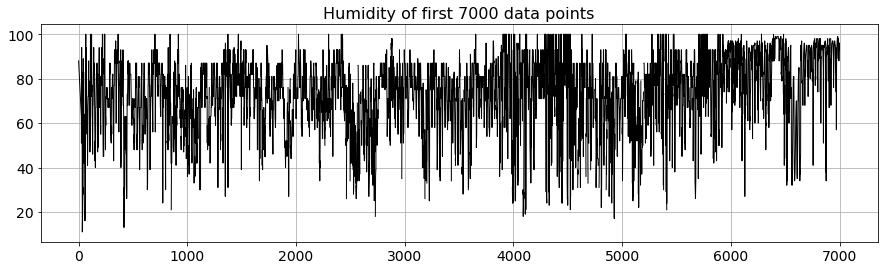

In [10]:
plot_train_points('humidity')

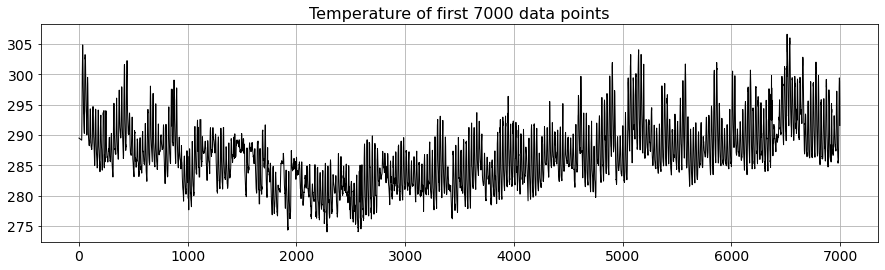

In [11]:
plot_train_points('temperature')

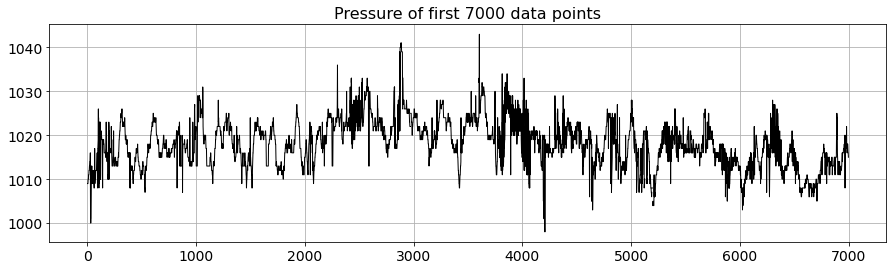

In [12]:
plot_train_points('pressure')

### Interpolate data points to fill up `NaN` values
We observed some `NaN` values in the dataset. We could just eliminate these points. But assuming that the changes in the parameters are not extremely abrupt, we could try to fill them using simple linear interpolation.

In [13]:
humidity_SF.interpolate(inplace=True)
humidity_SF.dropna(inplace=True)

temp_SF.interpolate(inplace=True)
temp_SF.dropna(inplace=True)

pressure_SF.interpolate(inplace=True)
pressure_SF.dropna(inplace=True)

In [14]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45252, 2)
(45252, 2)
(45252, 2)


### Train and test splits on the `Tp=7000`

In [15]:
train = np.array(humidity_SF['San Francisco'][:Tp])
test = np.array(humidity_SF['San Francisco'][Tp:])

In [16]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7000,)
Test data length: (38252,)


In [17]:
train=train.reshape(-1,1)
test=test.reshape(-1,1)

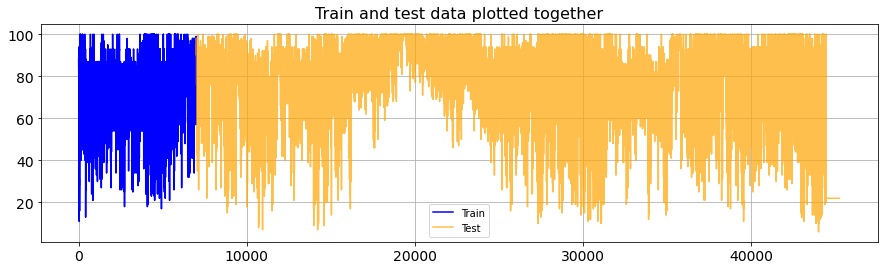

In [18]:
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together",fontsize=16)
plt.plot(np.arange(Tp),train,c='blue')
plt.plot(np.arange(Tp,45252),test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Choose the embedding or step size
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=8`. In more complex RNN and in particular for text processing, this is also called _embedding size_. The idea here is that **we are assuming that 8 hours of weather data can effectively predict the 9th hour data, and so on.**

In [19]:
step = 8

In [20]:
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

In [21]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7008,)
Test data length: (38260,)


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [22]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [23]:
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [24]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [25]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (7000, 1, 8) ,  (7000,)
Test data shape: (38252, 1, 8) ,  (38252,)


## Modeling

### Keras model with `SimpleRNN` layer

We build a simple function to define the RNN model. It uses a single neuron for the output layer because we are predicting a real-valued number here. As activation, it uses the ReLU function. Following arguments are supported.

- neurons in the RNN layer
- embedding length (i.e. the step length we chose)
- nenurons in the densely connected layer
- learning rate

In [26]:
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [27]:
model_humidity = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
model_humidity.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               17536     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,697
Trainable params: 21,697
Non-trainable params: 0
_________________________________________________________________


### A simple Keras `Callback` class to print progress of the training at regular epoch interval
Since the RNN training is usually long, we want to see regular updates about epochs finishing. However, we may not want to see this update every epoch as that may flood the output stream. Therefore, we write a simple custom `Callback` function to print the finishing update every 50th epoch. You can think of adding other bells and whistles to this function to print error and other metrics dynamically.

In [29]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Batch size and number of epochs

In [30]:
batch_size=8
num_epochs = 1000

### Training the model

In [31]:
model_humidity.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done


KeyboardInterrupt: 

### Plot RMSE loss over epochs
Note that the `loss` metric available in the `history` attribute of the model is the MSE loss and you have to take a square-root to compute the RMSE loss.

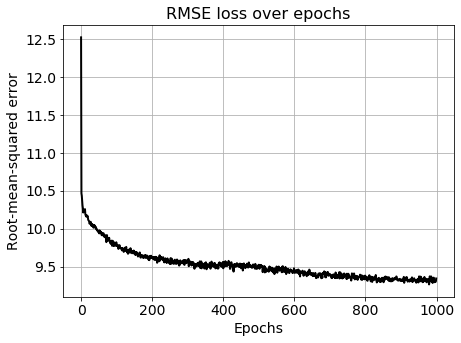

In [32]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Result and analysis

### What did the model see while training?
We are emphasizing and showing again what exactly the model see during training. If you look above, the model fitting code is,

```
model_humidity.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)
```

So, the model was fitted with `trainX` which is plotted below, and `trainY` which is just the 8 step shifted and shaped vector.

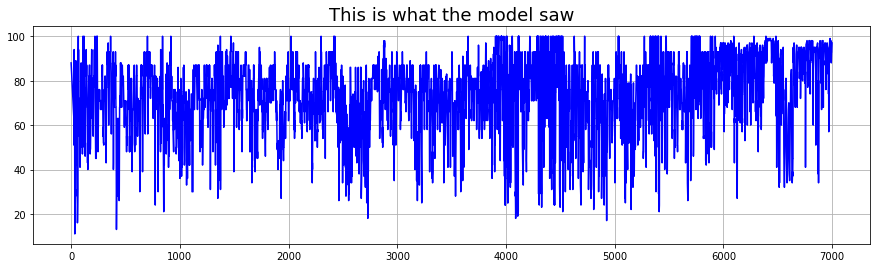

In [33]:
plt.figure(figsize=(15,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

### Now predict the future points
Now, we can generate predictions for the future by passing `testX` to the trained model.

In [57]:
trainPredict = model_humidity.predict(trainX)
testPredict= model_humidity.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

### See the magic!

When we plot the predicted vector, we see it matches closely the true values and that is amazing given how little training data was used and how far in the _future_ it had to predict. Time-series techniques like ARIMA, Exponential smoothing, cannot predict very far into the future and their confidence interval quickly grows beyond being useful.

**Note carefully how the model is able to predict sudden increase in humidity around time-points 12000. There was no indication of such shape or pattern of the data in the training set, yet, it is able to predict the general shape pretty well from the first 7000 data points!**

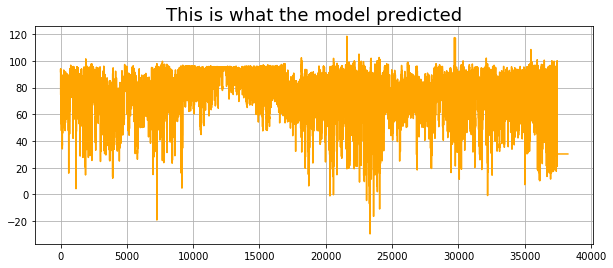

In [58]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

### Plotting the ground truth and model predictions together
We plot the ground truth and the model predictions together to show that it follows the general trends in the ground truth data pretty well. Considering less than 25% data was used for training, this is sort of amazing. The boundary between train and test splits is denoted by the vertical red line.

There are, of course, some obvious mistakes in the model predictions, such as humidity values going above 100 and some very low values. These can be pruned with post-processing or a better model can be built with propoer hyperparameter tuning.

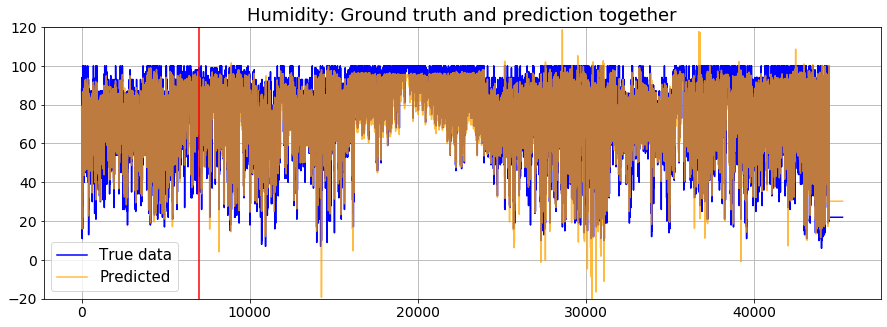

In [59]:
index = humidity_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Humidity: Ground truth and prediction together",fontsize=18)
plt.plot(index,humidity_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()

## Modeling the temperature data

Since we have covered modeling the humidity data step-by-step in detail, we will show the modeling with other two parameters - temperature and pressure - quickly with similar code but not with detailed text.

In [37]:
train = np.array(temp_SF['San Francisco'][:Tp])
test = np.array(temp_SF['San Francisco'][Tp:])

train = train.reshape(-1,1)
test = test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX, trainY = convertToMatrix(train,step)
testX, testY = convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [38]:
model_temp = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 2000

model_temp.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done
Epoch number 1050 done
Epoch number 1100 done
Epoch number 1150 done
Epoch number 1200 done
Epoch number 1250 done
Epoch number 1300 done
Epoch number 1350 done
Epoch number 1400 done
Epoch number 1450 done
Epoch number 1500 done
Epoch number 1550 done
Epoch number 1600 done
Epoch number 1650 done
Epoch number 1700 done
Epoch number 1750 done
Epoch number 1800 done
Epoch number 1850 done
Epoch number 1900 done
Epoch number 1950 done
Epoch number 2000 done


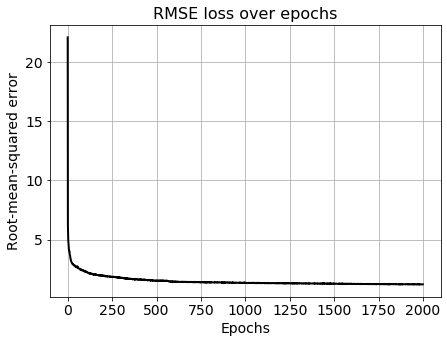

In [39]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_temp.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [40]:
trainPredict = model_temp.predict(trainX)
testPredict = model_temp.predict(testX)
predicted = np.concatenate((trainPredict,testPredict),axis=0)

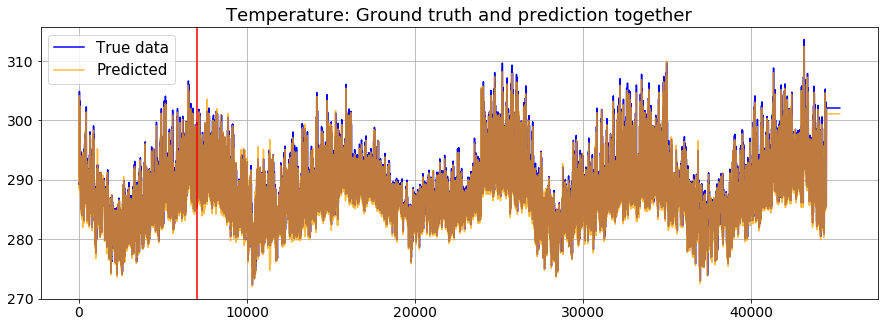

In [41]:
index = temp_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together",fontsize=18)
plt.plot(index,temp_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Modeling the atmospheric pressure data

In [42]:
train = np.array(pressure_SF['San Francisco'][:Tp])
test = np.array(pressure_SF['San Francisco'][Tp:])

train = train.reshape(-1,1)
test = test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
model_pressure = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 500

model_pressure.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done


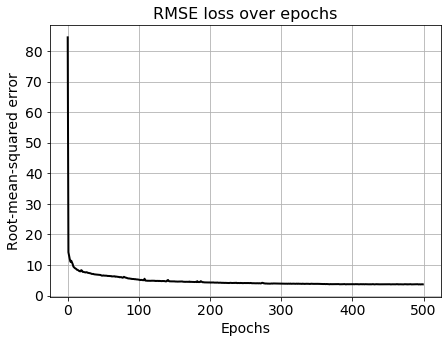

In [44]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_pressure.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [45]:
trainPredict = model_pressure.predict(trainX)
testPredict= model_pressure.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

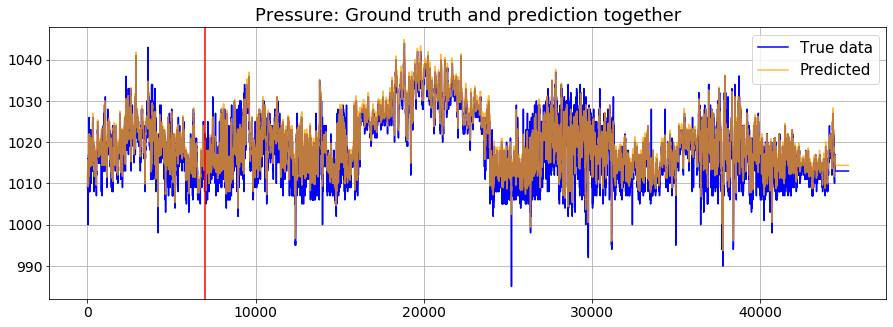

In [46]:
index = pressure_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Pressure: Ground truth and prediction together",fontsize=18)
plt.plot(index,pressure_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Again note how the model is able to predict sudden increase in pressure around time-points 18000-22000. There was no indication of such shape or pattern of the data in the training set (the boundary is denoted by the vertical red line), yet, it is able to predict the general shape pretty well from the first 7000 data points!**